In [1]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from deepface import DeepFace
import re
import csv
import json
from glob import glob
import shutil
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

In [6]:
pip install deepface

  Using cached deepface-0.0.93-py3-none-any.whl.metadata (30 kB)
Using cached deepface-0.0.93-py3-none-any.whl (108 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
pip install google-cloud-vision

In [15]:
# 비디오 파일 경로 설정
video_path = 'wemeet/지우2.mp4'  # 동영상 파일 경로
output_dir = 'wemeet/mp4_to_image'

# 저장할 디렉토리 생성
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 비디오 파일 읽기
video = cv2.VideoCapture(video_path)

# 비디오 정보 가져오기
fps = video.get(cv2.CAP_PROP_FPS)  # 초당 프레임 수 (frame per second)
count = 0

while video.isOpened():
    ret, frame = video.read()
    
    if not ret:
        break

    # 현재 프레임 번호 가져오기
    frame_id = int(video.get(cv2.CAP_PROP_POS_FRAMES))

    # 1초마다 프레임을 저장 (fps에 따라 결정)
    if frame_id % int(fps) == 0:
        filename = f"{output_dir}/picture_{count}.jpg"
        cv2.imwrite(filename, frame)
        print(f"Saved {filename}")
        count += 1

# 비디오 객체 해제
video.release()

Saved wemeet/mp4_to_image/picture_0.jpg
Saved wemeet/mp4_to_image/picture_1.jpg
Saved wemeet/mp4_to_image/picture_2.jpg
Saved wemeet/mp4_to_image/picture_3.jpg
Saved wemeet/mp4_to_image/picture_4.jpg
Saved wemeet/mp4_to_image/picture_5.jpg
Saved wemeet/mp4_to_image/picture_6.jpg
Saved wemeet/mp4_to_image/picture_7.jpg
Saved wemeet/mp4_to_image/picture_8.jpg
Saved wemeet/mp4_to_image/picture_9.jpg
Saved wemeet/mp4_to_image/picture_10.jpg
Saved wemeet/mp4_to_image/picture_11.jpg
Saved wemeet/mp4_to_image/picture_12.jpg
Saved wemeet/mp4_to_image/picture_13.jpg
Saved wemeet/mp4_to_image/picture_14.jpg
Saved wemeet/mp4_to_image/picture_15.jpg
Saved wemeet/mp4_to_image/picture_16.jpg
Saved wemeet/mp4_to_image/picture_17.jpg
Saved wemeet/mp4_to_image/picture_18.jpg
Saved wemeet/mp4_to_image/picture_19.jpg
Saved wemeet/mp4_to_image/picture_20.jpg
Saved wemeet/mp4_to_image/picture_21.jpg
Saved wemeet/mp4_to_image/picture_22.jpg
Saved wemeet/mp4_to_image/picture_23.jpg
Saved wemeet/mp4_to_image/

In [2]:
# 손가락 관절 좌표의 평균지점을 크롭하는 코드
import cv2
import mediapipe as mp
import numpy as np
import os
from glob import glob

# MediaPipe 초기화
mp_hands = mp.solutions.hands

# 입력 폴더 및 출력 설정
INPUT_FOLDER = 'wemeet/mp4_to_image'
OUTPUT_FOLDER = 'wemeet/image_crop'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

def calculate_average_point(landmarks, image_width, image_height):
    """
    손 랜드마크의 평균 좌표를 계산합니다.
    """
    x_coords = [lm.x * image_width for lm in landmarks]
    y_coords = [lm.y * image_height for lm in landmarks]
    
    avg_x = int(np.mean(x_coords))
    avg_y = int(np.mean(y_coords))
    
    return avg_x, avg_y

def crop_and_save_image(frame, center_x, center_y, original_filename, hand_label, size=500):
    """
    이미지를 중심 좌표로 크롭하고 저장합니다.
    """
    half_size = size // 2
    height, width = frame.shape[:2]
    
    # 크롭 영역 계산
    x1 = max(0, center_x - half_size)
    y1 = max(0, center_y - half_size)
    x2 = min(width, center_x + half_size)
    y2 = min(height, center_y + half_size)
    
    if x1 >= x2 or y1 >= y2:
        return
        
    # 이미지 크롭
    cropped = frame[y1:y2, x1:x2]
    
    # 원본 파일명에서 확장자 제거
    base_filename = os.path.splitext(original_filename)[0]
    # 새로운 파일명 형식으로 저장 (원본파일명_left 또는 _right.jpg)
    filename = f"{base_filename}_{hand_label}.jpg"
    output_path = os.path.join(OUTPUT_FOLDER, filename)
    cv2.imwrite(output_path, cropped)
    print(f"{hand_label.capitalize()} 손 크롭 이미지 저장 완료: {filename}")

# 메인 코드
with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5
) as hands:
    # 입력 폴더에서 모든 이미지 파일 가져오기
    image_files = glob(os.path.join(INPUT_FOLDER, '*.jpg')) + \
                 glob(os.path.join(INPUT_FOLDER, '*.png'))
    
    for image_path in image_files:
        # 원본 파일명 추출
        original_filename = os.path.basename(image_path)
        
        # 이미지 읽기
        frame = cv2.imread(image_path)
        if frame is None:
            print(f"이미지를 읽을 수 없습니다: {image_path}")
            continue
            
        # RGB 변환 및 손 좌표 탐지
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)
        
        if results.multi_hand_landmarks and results.multi_handedness:
            image_height, image_width = frame.shape[:2]
            
            # 각 손에 대해 처리
            for hand_idx, (hand_landmarks, handedness) in enumerate(
                zip(results.multi_hand_landmarks, results.multi_handedness)
            ):
                # 중심점 계산 (손가락 관절 좌표의 평균)
                center_x, center_y = calculate_average_point(
                    hand_landmarks.landmark, image_width, image_height
                )
                
                # 왼손 또는 오른손 라벨 가져오기
                hand_label = "left" if handedness.classification[0].label == "Left" else "right"
                
                # 이미지 크롭 및 저장
                crop_and_save_image(frame, center_x, center_y, original_filename, hand_label)
        else:
            print(f"손을 탐지할 수 없습니다: {image_path}")

Left 손 크롭 이미지 저장 완료: picture_0_left.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_1.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_10.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_100.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_101.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_102.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_103.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_104.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_105.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_106.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_107.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_108.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_109.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_11.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_110.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_111.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_112.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_113.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_114.jpg
손을 탐지할 수 없습니다: wemeet/mp4_to_image\picture_115

In [3]:
# resnet 적용
# 코드 수정
# 설정
MODEL_PATH = 'wemeet/resnet.pth'
IMAGE_FOLDER = 'wemeet/image_crop'
OUTPUT_FOLDER = 'wemeet/predict'
HAMBURGER_FOLDER = os.path.join(OUTPUT_FOLDER, 'hamburger')
NOT_HAMBURGER_FOLDER = os.path.join(OUTPUT_FOLDER, 'not_hamburger')
os.makedirs(HAMBURGER_FOLDER, exist_ok=True)
os.makedirs(NOT_HAMBURGER_FOLDER, exist_ok=True)
classes = ['hamburger', 'not hamburger']

# 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18()
model.fc = torch.nn.Linear(model.fc.in_features, len(classes))
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

# 전처리
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 배치 처리 함수
def process_batch(model, all_images, device):
    input_batch = torch.cat(all_images).to(device)
    with torch.no_grad():
        outputs = model(input_batch)
        _, predicted = torch.max(outputs, 1)
    return predicted

# 분류 및 이동 함수
def classify_and_copy(model, all_images, all_files):
    if all_images:
        predicted = process_batch(model, all_images, device)
        for i, file in enumerate(all_files):
            label = classes[predicted[i].item()]
            destination = os.path.join(
                HAMBURGER_FOLDER if label == 'hamburger' else NOT_HAMBURGER_FOLDER, file
            )
            try:
                shutil.copy(os.path.join(IMAGE_FOLDER, file), destination)
                print(f"이미지: {file}, 예측 결과: {label}, 저장 위치: {destination}")
            except FileNotFoundError:
                print(f"파일이 존재하지 않습니다: {file}")

# 이미지 처리
batch_size = 32
all_images, all_files = [], []
for image_file in os.listdir(IMAGE_FOLDER):
    if not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    image_path = os.path.join(IMAGE_FOLDER, image_file)
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)
    all_images.append(input_tensor)
    all_files.append(image_file)

    if len(all_images) >= batch_size:
        classify_and_copy(model, all_images, all_files)
        all_images, all_files = [], []

# 남은 이미지 처리
classify_and_copy(model, all_images, all_files)


이미지: picture_0_left.jpg, 예측 결과: hamburger, 저장 위치: wemeet/predict\hamburger\picture_0_left.jpg
이미지: picture_117_right.jpg, 예측 결과: not hamburger, 저장 위치: wemeet/predict\not_hamburger\picture_117_right.jpg
이미지: picture_118_left.jpg, 예측 결과: hamburger, 저장 위치: wemeet/predict\hamburger\picture_118_left.jpg
이미지: picture_118_right.jpg, 예측 결과: hamburger, 저장 위치: wemeet/predict\hamburger\picture_118_right.jpg
이미지: picture_120_left.jpg, 예측 결과: not hamburger, 저장 위치: wemeet/predict\not_hamburger\picture_120_left.jpg
이미지: picture_120_right.jpg, 예측 결과: not hamburger, 저장 위치: wemeet/predict\not_hamburger\picture_120_right.jpg
이미지: picture_121_right.jpg, 예측 결과: not hamburger, 저장 위치: wemeet/predict\not_hamburger\picture_121_right.jpg
이미지: picture_122_left.jpg, 예측 결과: hamburger, 저장 위치: wemeet/predict\hamburger\picture_122_left.jpg
이미지: picture_126_left.jpg, 예측 결과: not hamburger, 저장 위치: wemeet/predict\not_hamburger\picture_126_left.jpg
이미지: picture_128_right.jpg, 예측 결과: hamburger, 저장 위치: wemeet/predict\hambur

In [4]:
# resnet 적용 후 google cloud vision api 적용해서 더 걸러내기
import os
import shutil
from google.cloud import vision

# Google Cloud Vision API 인증
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = ""  # JSON 파일 경로

def detect_eating_activity(image_path):
    client = vision.ImageAnnotatorClient()
    
    with open(image_path, 'rb') as image_file:
        content = image_file.read()
    
    image = vision.Image(content=content)
    
    features = [
        vision.Feature.Type.LABEL_DETECTION,
    ]
    
    request = vision.AnnotateImageRequest(
        image=image,
        features=[vision.Feature(type_=feature) for feature in features]
    )
    
    response = client.annotate_image(request=request)
    
    # Eating과 Food에 대해서만 확인
    eating_score = 0.0
    food_score = 0.0
    
    for label in response.label_annotations:
        if label.description.lower() == 'eating':
            eating_score = label.score
        elif label.description.lower() == 'food':
            food_score = label.score
    
    return {
        'eating_score': eating_score,
        'food_score': food_score
    }

def process_images(input_folder, output_folder, confidence_threshold=0.75):
    # 출력 폴더가 없으면 생성
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # 지원하는 이미지 확장자
    valid_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    
    # 입력 폴더의 모든 파일 처리
    for filename in os.listdir(input_folder):
        if any(filename.lower().endswith(ext) for ext in valid_extensions):
            input_path = os.path.join(input_folder, filename)
            
            try:
                result = detect_eating_activity(input_path)
                
                # Eating 점수가 임계값보다 높으면 이미지 복사
                if result['eating_score'] >= confidence_threshold:
                    output_path = os.path.join(output_folder, filename)
                    shutil.copy2(input_path, output_path)
                    print(f"복사됨: {filename} (Eating 점수: {result['eating_score']:.2%})")
                else:
                    print(f"건너뜀: {filename} (Eating 점수: {result['eating_score']:.2%})")
                    
            except Exception as e:
                print(f"오류 발생 ({filename}): {str(e)}")

def main():
    input_folder = "wemeet/predict/hamburger"  # 입력 폴더 경로
    output_folder = "wemeet/predict_google_api"  # 출력 폴더 경로
    confidence_threshold = 0.75  # 75% 임계값
    
    try:
        process_images(input_folder, output_folder, confidence_threshold)
        print("\n처리가 완료되었습니다.")
            
    except Exception as e:
        print(f"오류 발생: {str(e)}")

if __name__ == "__main__":
    main()


건너뜀: picture_0_left.jpg (Eating 점수: 65.48%)
건너뜀: picture_118_left.jpg (Eating 점수: 0.00%)
건너뜀: picture_118_right.jpg (Eating 점수: 0.00%)
건너뜀: picture_122_left.jpg (Eating 점수: 0.00%)
복사됨: picture_128_right.jpg (Eating 점수: 80.27%)
건너뜀: picture_130_right.jpg (Eating 점수: 69.75%)
건너뜀: picture_131_right.jpg (Eating 점수: 0.00%)
건너뜀: picture_136_right.jpg (Eating 점수: 0.00%)
건너뜀: picture_137_right.jpg (Eating 점수: 0.00%)
건너뜀: picture_145_left.jpg (Eating 점수: 0.00%)
복사됨: picture_154_right.jpg (Eating 점수: 81.04%)
복사됨: picture_156_right.jpg (Eating 점수: 90.94%)
복사됨: picture_157_right.jpg (Eating 점수: 93.24%)
건너뜀: picture_164_left.jpg (Eating 점수: 0.00%)
건너뜀: picture_176_right.jpg (Eating 점수: 0.00%)
건너뜀: picture_195_left.jpg (Eating 점수: 0.00%)
건너뜀: picture_200_right.jpg (Eating 점수: 0.00%)
건너뜀: picture_202_right.jpg (Eating 점수: 0.00%)
건너뜀: picture_203_right.jpg (Eating 점수: 0.00%)
건너뜀: picture_220_left.jpg (Eating 점수: 73.77%)
건너뜀: picture_221_left.jpg (Eating 점수: 68.76%)
복사됨: picture_222_left.jpg (Eating 점수

In [8]:
pip show mediapipe

Name: mediapipe
Version: 0.10.20
Summary: MediaPipe is the simplest way for researchers and developers to build world-class ML solutions and applications for mobile, edge, cloud and the web.
Home-page: https://github.com/google/mediapipe
Author: The MediaPipe Authors
Author-email: mediapipe@google.com
License: Apache 2.0
Location: c:\Users\210421\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: absl-py, attrs, flatbuffers, jax, jaxlib, matplotlib, numpy, opencv-contrib-python, protobuf, sentencepiece, sounddevice
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Mediapipe 초기화
mp_hands = mp.solutions.hands
mp_face_mesh = mp.solutions.face_mesh
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# 경로 정의
input_folder = 'wemeet/predict_google_api'     # 위에 google_api 사용하면서 수정 : input_folder = 'wemeet/predict/hamburger' --> 'wemeet/predict_google_api'
source_folder = 'wemeet/mp4_to_image'
find_original_folder = 'wemeet/find_original_image'
output_folder = 'wemeet/final_output'
distance_threshold = 450

# 필요한 폴더 생성
for folder in [find_original_folder, output_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# 파일명에서 _left, _right 제거하는 함수
def get_base_name(filename):
    """
    _left, _right 접미어가 있으면 제거하고 기본 파일명만 반환.
    """
    filename = filename.rsplit('.', 1)[0]  # 확장자 제거
    if filename.endswith('_left'):
        return filename[:-5]  # '_left' 제거
    elif filename.endswith('_right'):
        return filename[:-6]  # '_right' 제거
    return filename

# Step 1: input 폴더의 기본 이름 목록 생성
input_files = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]
input_basenames = list(set(get_base_name(f) for f in input_files))

# 디버깅 출력
print("Updated input_basenames:", input_basenames)

# Step 2: source 폴더에서 매칭되는 이미지 찾아서 find_original_folder로 복사
source_files = [f for f in os.listdir(source_folder) if f.endswith('.jpg')]
source_basenames = list(set(get_base_name(f) for f in source_files))

found_count = 0

for source_file in source_files:
    source_base = get_base_name(source_file)  # 여기서 수정

    if source_base in input_basenames:
        source_path = os.path.join(source_folder, source_file)
        dest_path = os.path.join(find_original_folder, source_file)
        try:
            shutil.copy2(source_path, dest_path)
            found_count += 1
            print(f"Copied {source_file} to {find_original_folder}")
        except Exception as e:
            print(f"Error copying {source_file}: {e}")
    else:
        print(f"Skipping {source_file}, not found in input_basenames")

print(f"Found and copied {found_count} matching images to {find_original_folder}")

# Step 3: find_original_folder의 이미지들에 대해 거리 계산 및 조건에 맞는 이미지 복사
found_files = [f for f in os.listdir(find_original_folder) if f.endswith('.jpg')]
processed_count = 0
saved_count = 0

for img_file in found_files:
    img_path = os.path.join(find_original_folder, img_file)
    frame = cv2.imread(img_path)
    
    if frame is None:
        print(f"Failed to read image: {img_file}")
        continue

    # 좌표 추출
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # 코 좌표 추출
    face_results = face_mesh.process(frame_rgb)
    nose_coordinates = None
    if face_results.multi_face_landmarks:
        landmarks = face_results.multi_face_landmarks[0].landmark
        height, width, _ = frame.shape
        nose_coordinates = (int(landmarks[4].x * width), int(landmarks[4].y * height))

    # 손목 좌표 추출
    hand_results = hands.process(frame_rgb)
    wrist_coordinates = None
    if hand_results.multi_hand_landmarks:
        landmarks = hand_results.multi_hand_landmarks[0].landmark
        height, width, _ = frame.shape
        wrist_coordinates = (int(landmarks[0].x * width), int(landmarks[0].y * height))

    # 거리 계산 및 조건 확인
    if wrist_coordinates is not None and nose_coordinates is not None:
        distance = np.sqrt((nose_coordinates[0] - wrist_coordinates[0]) ** 2 + 
                         (nose_coordinates[1] - wrist_coordinates[1]) ** 2)

        if distance <= distance_threshold:
            saved_count += 1
            output_path = os.path.join(output_folder, img_file)
            try:
                shutil.copy2(img_path, output_path)
                print(f"Image {img_file}: Distance = {distance:.2f} (Saved)")
            except Exception as e:
                print(f"Error copying {img_file}: {e}")
    
    processed_count += 1

# 최종 결과 출력
print(f"\nSummary:")
print(f"Total input base names: {len(input_basenames)}")
print(f"Total matching images found: {found_count}")
print(f"Processed images from find_original_folder: {processed_count}")
print(f"Images with distance <= {distance_threshold}: {saved_count}")
print(f"Final images copied to {output_folder}")


Updated input_basenames: ['picture_482', 'picture_128', 'picture_224', 'picture_240', 'picture_222', 'picture_36', 'picture_9', 'picture_157', 'picture_398', 'picture_154', 'picture_156', 'picture_478', 'picture_34', 'picture_37', 'picture_35', 'picture_423']
Skipping picture_0.jpg, not found in input_basenames
Skipping picture_1.jpg, not found in input_basenames
Skipping picture_10.jpg, not found in input_basenames
Skipping picture_100.jpg, not found in input_basenames
Skipping picture_101.jpg, not found in input_basenames
Skipping picture_102.jpg, not found in input_basenames
Skipping picture_103.jpg, not found in input_basenames
Skipping picture_104.jpg, not found in input_basenames
Skipping picture_105.jpg, not found in input_basenames
Skipping picture_106.jpg, not found in input_basenames
Skipping picture_107.jpg, not found in input_basenames
Skipping picture_108.jpg, not found in input_basenames
Skipping picture_109.jpg, not found in input_basenames
Skipping picture_11.jpg, not f

# 행동

In [7]:
import cv2
import mediapipe as mp
import numpy as np
import os

# MediaPipe Pose 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

def classify_movement_probabilities(cumulative_x, cumulative_y, th_1=2.0, th_2=0.5, noise_threshold_x=0.01, noise_threshold_y=0.01):
    """
    x 변화량 / y 변화량 비율을 기준으로 움직임의 확률을 계산합니다.
    """
    movements = {
        "positive": 0,
        "negative": 0,
        "neutral": 0
    }
    total_frames = len(cumulative_x)

    for i in range(1, total_frames):
        delta_x = abs(cumulative_x[i] - cumulative_x[i - 1])
        delta_y = abs(cumulative_y[i] - cumulative_y[i - 1])

        # 노이즈 제거
        if delta_x < noise_threshold_x and delta_y < noise_threshold_y:
            movements["neutral"] += 1
        else:
            a = delta_x / (delta_y + 1e-6)
            if a > th_1:
                movements["negative"] += 1
            elif a < th_2:
                movements["positive"] += 1
            else:
                movements["neutral"] += 1

    # 총 움직임 수
    total_movement = movements["positive"] + movements["negative"]
    
    if total_movement > 0:
        probabilities = {
            "positive": (movements["positive"] / total_movement) * 100,
            "negative": (movements["negative"] / total_movement) * 100,
            "neutral": 0  # 중립은 제외
        }
    else:
        probabilities = {"positive": 50, "negative": 50, "neutral": 0}  # 기본값 설정
    
    return probabilities

def process_video_with_probabilities(video_path, start_time, duration=10, fps=30, th_1=2.0, th_2=0.5, noise_threshold_x=0.01, noise_threshold_y=0.01):
    """
    입력 영상에서 특정 시간 구간의 움직임을 확률 기반으로 분석합니다.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return None, None, None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    start_frame = int(start_time * fps)
    end_frame = min(start_frame + int(duration * fps), total_frames)

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    nose_positions = []
    cumulative_x = [0]
    cumulative_y = [0]
    frame_count = start_frame

    while cap.isOpened() and frame_count < end_frame:
        ret, frame = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image)

        if results.pose_landmarks:
            nose = results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE]
            nose_positions.append((nose.x, nose.y))

            if len(nose_positions) > 1:
                prev_x, prev_y = nose_positions[-2]
                curr_x, curr_y = nose_positions[-1]

                delta_x = abs(curr_x - prev_x)
                delta_y = abs(curr_y - prev_y)

                cumulative_x.append(cumulative_x[-1] + delta_x)
                cumulative_y.append(cumulative_y[-1] + delta_y)

        frame_count += 1

    cap.release()

    if len(cumulative_x) <= 1 or len(cumulative_y) <= 1:
        print(f"No valid movement data detected in video {video_path}")
        return None, None, None

    probabilities = classify_movement_probabilities(
        cumulative_x, cumulative_y, th_1, th_2, noise_threshold_x, noise_threshold_y
    )
    return probabilities, cumulative_x, cumulative_y

def process_images_for_video_analysis(video_path, image_folder, duration=10, fps=30):
    """
    이미지 파일 이름에서 시간을 추출하여 비디오를 분석하고 CSV 파일로 저장합니다.
    """
    image_files = [f for f in os.listdir(image_folder) if f.startswith("picture_") and f.endswith((".jpg", ".png"))]

    results = []  # CSV 저장을 위한 리스트
    positive_values = []
    negative_values = []

    for image_file in image_files:
        try:
            time_str = image_file.split("_")[1].split(".")[0]
            start_time = int(time_str)
        except (IndexError, ValueError):
            print(f"Invalid file format: {image_file}")
            continue

        print(f"\nAnalyzing movement for {image_file} (Start Time: {start_time}s)")

        probabilities, cumulative_x, cumulative_y = process_video_with_probabilities(
            video_path, start_time=start_time, duration=duration, fps=fps
        )

        if probabilities:
            positive_raw = probabilities['positive']
            negative_raw = probabilities['negative']
            total = positive_raw + negative_raw

            if total > 0:
                positive_normalized = (positive_raw / total) * 100
                negative_normalized = (negative_raw / total) * 100
            else:
                positive_normalized = 50
                negative_normalized = 50

            positive_values.append(positive_normalized)
            negative_values.append(negative_normalized)

            print(f"Normalized Movement Probabilities (from {start_time}s to {start_time + duration}s):")
            print(f"- Positive (긍정): {positive_normalized:.2f}%")
            print(f"- Negative (부정): {negative_normalized:.2f}%")

            # CSV 저장을 위한 데이터 추가
            results.append({
                "Image File": image_file,
                "Start Time (s)": start_time,
                "Positive (%)": positive_normalized,
                "Negative (%)": negative_normalized
            })

    positive_avg = sum(positive_values) / len(positive_values) if positive_values else 50
    negative_avg = sum(negative_values) / len(negative_values) if negative_values else 50

    print("\nFinal Results:")
    print(f"Average Positive (긍정 평균): {positive_avg:.2f}%")
    print(f"Average Negative (부정 평균): {negative_avg:.2f}%")

    # CSV 파일 저장
    df = pd.DataFrame(results)
    csv_output_path = "movement_analysis_results.csv"
    df.to_csv(csv_output_path, index=False, encoding="utf-8-sig")

    print(f"✅ CSV 파일 저장 완료: {csv_output_path}")

    return positive_avg, negative_avg

# 비디오 경로 및 이미지 폴더 경로
video_path = "wemeet/지우2.mp4"
image_folder = "wemeet/final_output"

# 이미지 파일 처리 및 CSV 저장
positive_avg, negative_avg = process_images_for_video_analysis(video_path, image_folder)

# 결과 저장
positive_behave = positive_avg
negative_behave = negative_avg

print(f"Average Positive: {positive_avg:.2f}%")
print(f"Average Negative: {negative_avg:.2f}%")



Analyzing movement for picture_154.jpg (Start Time: 154s)
Normalized Movement Probabilities (from 154s to 164s):
- Positive (긍정): 47.06%
- Negative (부정): 52.94%

Analyzing movement for picture_156.jpg (Start Time: 156s)
Normalized Movement Probabilities (from 156s to 166s):
- Positive (긍정): 57.69%
- Negative (부정): 42.31%

Analyzing movement for picture_157.jpg (Start Time: 157s)
Normalized Movement Probabilities (from 157s to 167s):
- Positive (긍정): 61.54%
- Negative (부정): 38.46%

Analyzing movement for picture_224.jpg (Start Time: 224s)
Normalized Movement Probabilities (from 224s to 234s):
- Positive (긍정): 31.25%
- Negative (부정): 68.75%

Analyzing movement for picture_34.jpg (Start Time: 34s)
Normalized Movement Probabilities (from 34s to 44s):
- Positive (긍정): 0.00%
- Negative (부정): 100.00%

Analyzing movement for picture_37.jpg (Start Time: 37s)
Normalized Movement Probabilities (from 37s to 47s):
- Positive (긍정): 40.00%
- Negative (부정): 60.00%

Analyzing movement for picture_398.

In [8]:
# 경로 설정
FINAL_OUTPUT_FOLDER = "wemeet/final_output"
ORIGINAL_IMAGE_FOLDER = "wemeet/mp4_to_image"
DEEPFACE_OUTPUT_FOLDER = "wemeet/deepface_emotions"
os.makedirs(DEEPFACE_OUTPUT_FOLDER, exist_ok=True)

# 결과 저장 경로
RESULT_CSV = os.path.join(DEEPFACE_OUTPUT_FOLDER, "emotion_analysis_full.csv")
RESULT_JSON = os.path.join(DEEPFACE_OUTPUT_FOLDER, "emotion_analysis_full.json")

# DeepFace가 반환하는 모든 감정
ALL_EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# 프레임 번호 추출 함수
def extract_frame_number(filename):
    match = re.search(r'_(\d+)\.jpg', filename)
    return int(match.group(1)) if match else None

# 섭취 순간 프레임 읽기 및 정렬
eating_frames = []
for img_file in os.listdir(FINAL_OUTPUT_FOLDER):
    frame_number = extract_frame_number(img_file)
    if frame_number is not None:
        eating_frames.append(frame_number)

eating_frames.sort()

# 연속된 프레임 묶기
grouped_frames = []
current_group = [eating_frames[0]]

for i in range(1, len(eating_frames)):
    if eating_frames[i] - eating_frames[i - 1] <= 3:  # 간격 3 이하
        current_group.append(eating_frames[i])
    else:
        grouped_frames.append(current_group)
        current_group = [eating_frames[i]]

grouped_frames.append(current_group)  # 마지막 그룹 추가

# 감정 분석 결과 저장용 리스트
analysis_results = []

# 각 그룹의 전후 프레임 포함하여 DeepFace 감정 분석 수행
for group in grouped_frames:
    group_result = {
        "group": group,
        "frames_analyzed": [],
        "emotions": {}
    }
    start_frame = max(1, group[0] - 5)  # 전 5프레임
    end_frame = group[-1] + 5           # 후 5프레임
    frames_to_analyze = range(start_frame, end_frame + 1)

    for frame in frames_to_analyze:
        img_file = f"picture_{frame}.jpg"
        img_path = os.path.join(ORIGINAL_IMAGE_FOLDER, img_file)

        if not os.path.exists(img_path):  # 이미지가 없으면 스킵
            print(f"Image {img_file} not found, skipping.")
            continue

        try:
            # DeepFace 분석 수행
            analysis = DeepFace.analyze(img_path, actions=['emotion'], enforce_detection=False)
            if isinstance(analysis, list):
                analysis = analysis[0]

            # 결과 저장
            group_result["frames_analyzed"].append(frame)
            group_result["emotions"][frame] = {
                "dominant_emotion": analysis.get("dominant_emotion", "Unknown"),
                "emotion_probabilities": {emotion: analysis.get("emotion", {}).get(emotion, 0) for emotion in ALL_EMOTIONS}
            }

            # 출력
            print(f"Frame {frame} ({img_file}): {group_result['emotions'][frame]}")

        except Exception as e:
            print(f"Error processing {img_file}: {str(e)}")

    analysis_results.append(group_result)

# 주요 감정 통계 계산 및 전후 비교
for result in analysis_results:
    group = result["group"]
    emotions = result["emotions"]
    emotion_values = list(emotions.values())

    # 감정 확률 평균 계산
    all_emotions = {emotion: [] for emotion in ALL_EMOTIONS}
    for frame_data in emotion_values:
        for emotion, prob in frame_data["emotion_probabilities"].items():
            all_emotions[emotion].append(prob)

    avg_emotions = {emotion: np.mean(probs) if probs else 0 for emotion, probs in all_emotions.items()}
    print(f"Group {group}: Average Emotions: {avg_emotions}")

    # 긍정/부정 감정 비율 계산
    positive_ratio = avg_emotions.get("happy", 0) + avg_emotions.get("neutral", 0)
    negative_ratio = sum(avg_emotions.get(key, 0) for key in ["fear", "angry", "sad"])
    print(f"Group {group}: Positive Ratio: {positive_ratio}, Negative Ratio: {negative_ratio}")

    # 전후 비교
    if len(emotion_values) >= 7:  # 최소 7프레임: 전 3, 섭취, 후 3
        before_emotions = emotion_values[:3]  # 전 3프레임
        after_emotions = emotion_values[-3:]  # 후 3프레임

        avg_before = {emotion: np.mean([frame["emotion_probabilities"][emotion] for frame in before_emotions])
                      for emotion in ALL_EMOTIONS}
        avg_after = {emotion: np.mean([frame["emotion_probabilities"][emotion] for frame in after_emotions])
                     for emotion in ALL_EMOTIONS}

        print(f"Group {group}: Before: {avg_before}, After: {avg_after}")

# 결과 CSV로 저장
with open(RESULT_CSV, mode='w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Group", "Frame", "Dominant Emotion", "Emotion Probabilities"])
    for result in analysis_results:
        for frame, data in result["emotions"].items():
            writer.writerow([
                result["group"],
                frame,
                data["dominant_emotion"],
                data["emotion_probabilities"]
            ])

# 결과 JSON으로 저장
with open(RESULT_JSON, mode='w', encoding='utf-8') as jsonfile:
    json.dump(analysis_results, jsonfile, ensure_ascii=False, indent=4)

print(f"Analysis completed. Results saved to:\nCSV: {RESULT_CSV}\nJSON: {RESULT_JSON}")

Frame 4 (picture_4.jpg): {'dominant_emotion': 'fear', 'emotion_probabilities': {'angry': 4.238125309348106, 'disgust': 0.04877585161011666, 'fear': 75.50334334373474, 'happy': 2.098776027560234, 'sad': 5.900701880455017, 'surprise': 0.1966776791960001, 'neutral': 12.013594061136246}}
Frame 5 (picture_5.jpg): {'dominant_emotion': 'sad', 'emotion_probabilities': {'angry': 0.0004901696229353547, 'disgust': 4.6478931814419866e-08, 'fear': 0.0019797251297859475, 'happy': 20.997337996959686, 'sad': 78.39679718017578, 'surprise': 2.2907618510425998e-09, 'neutral': 0.603393604978919}}
Frame 6 (picture_6.jpg): {'dominant_emotion': 'fear', 'emotion_probabilities': {'angry': 0.2336752274587886, 'disgust': 0.006346752721529616, 'fear': 52.117279298143345, 'happy': 1.2887664907435472, 'sad': 22.24962247905865, 'surprise': 2.477721831364741, 'neutral': 21.626585520898434}}
Frame 7 (picture_7.jpg): {'dominant_emotion': 'sad', 'emotion_probabilities': {'angry': 2.7237843722105026, 'disgust': 0.0171896

Group [154, 156, 157]:
  Before Average: angry       29.505082
disgust      0.000019
fear         9.292994
happy        1.613637
sad         50.861914
surprise     0.030117
neutral      8.696240
dtype: float64
  After Average: angry       22.213612
disgust      0.000151
fear         3.470903
happy        5.757368
sad         34.467885
surprise     0.035057
neutral     34.055026
dtype: float64
  Emotion Changes: angry       -7.291470
disgust      0.000131
fear        -5.822091
happy        4.143731
sad        -16.394029
surprise     0.004940
neutral     25.358786
dtype: float64


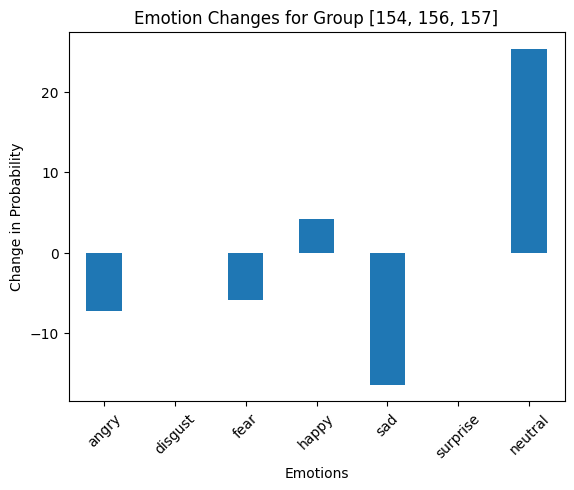

Group [224]:
  Before Average: angry        4.107244
disgust      0.027335
fear        30.156792
happy        0.773674
sad         30.720612
surprise     0.407168
neutral     33.807174
dtype: float64
  After Average: angry       36.048435
disgust      0.002321
fear        30.507256
happy        0.000465
sad         26.222627
surprise     0.001749
neutral      7.217145
dtype: float64
  Emotion Changes: angry       31.941191
disgust     -0.025014
fear         0.350464
happy       -0.773209
sad         -4.497985
surprise    -0.405419
neutral    -26.590030
dtype: float64


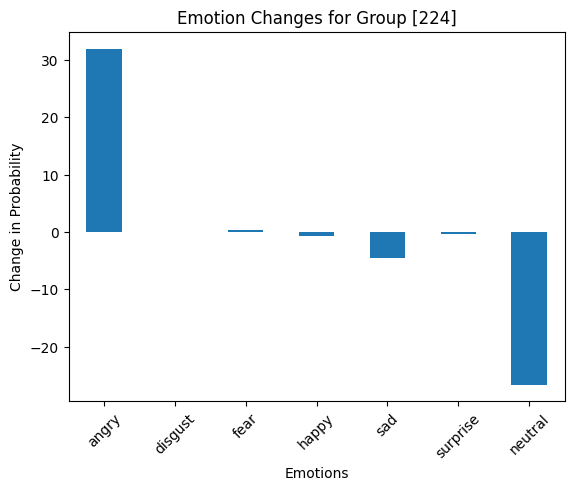

Group [34, 37]:
  Before Average: angry        2.296781
disgust      0.052586
fear        15.921211
happy       20.599801
sad         15.577348
surprise     0.068650
neutral     45.483625
dtype: float64
  After Average: angry        5.216898
disgust      0.016559
fear        20.446505
happy        2.572411
sad         22.969110
surprise     0.968792
neutral     47.809726
dtype: float64
  Emotion Changes: angry        2.920118
disgust     -0.036027
fear         4.525294
happy      -18.027390
sad          7.391762
surprise     0.900142
neutral      2.326101
dtype: float64


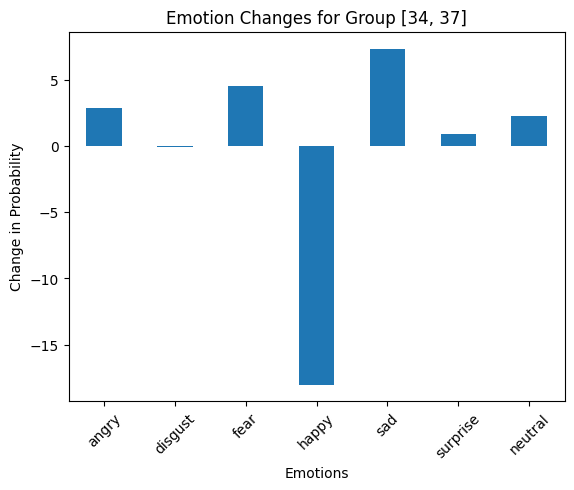

Group [398]:
  Before Average: angry       11.507576
disgust      0.008215
fear        38.517327
happy        0.256809
sad         41.517513
surprise     1.016222
neutral      7.176337
dtype: float64
  After Average: angry        1.145932
disgust      0.003839
fear        27.141958
happy        0.741980
sad         44.401441
surprise     0.086531
neutral     26.478320
dtype: float64
  Emotion Changes: angry      -10.361644
disgust     -0.004377
fear       -11.375369
happy        0.485171
sad          2.883927
surprise    -0.929691
neutral     19.301984
dtype: float64


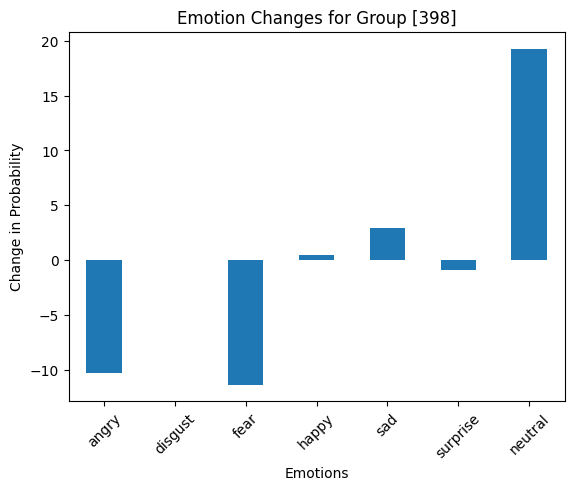

Group [478]:
  Before Average: angry        4.114587
disgust      0.006201
fear        21.619427
happy        0.259751
sad         58.646868
surprise     0.293183
neutral     15.059984
dtype: float64
  After Average: angry        4.918373
disgust      0.000017
fear         6.419985
happy        0.002769
sad         80.833421
surprise     6.831208
neutral      0.994228
dtype: float64
  Emotion Changes: angry        0.803786
disgust     -0.006184
fear       -15.199442
happy       -0.256981
sad         22.186553
surprise     6.538024
neutral    -14.065755
dtype: float64


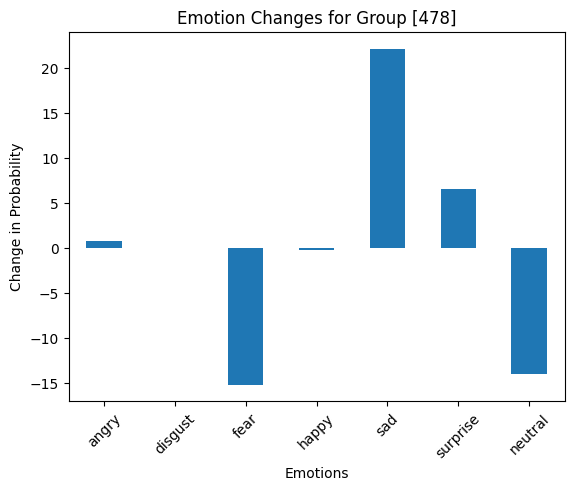

Group [482]:
  Before Average: angry        6.807290
disgust      0.006585
fear        31.083647
happy        0.253093
sad         49.864484
surprise     6.964015
neutral      5.020882
dtype: float64
  After Average: angry       12.938704
disgust      0.001740
fear         9.044260
happy       20.263840
sad         44.534178
surprise     0.122501
neutral     13.094778
dtype: float64
  Emotion Changes: angry        6.131414
disgust     -0.004845
fear       -22.039387
happy       20.010747
sad         -5.330307
surprise    -6.841515
neutral      8.073896
dtype: float64


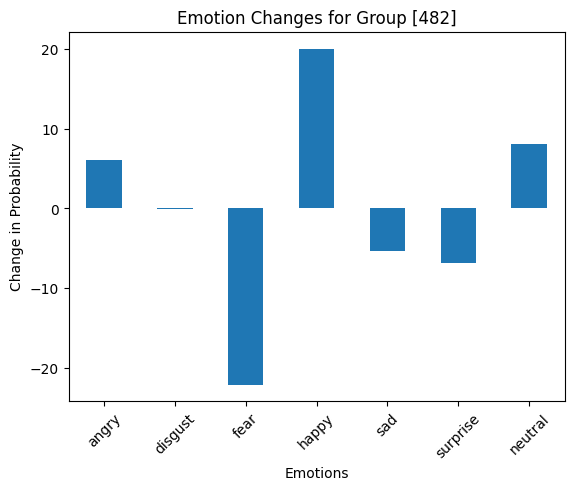

Group [9]:
  Before Average: angry        1.544025
disgust      0.014809
fear        48.430069
happy        4.955269
sad         33.488030
surprise     0.569860
neutral     10.997939
dtype: float64
  After Average: angry        3.687503
disgust      0.009188
fear        34.044776
happy       19.740320
sad         25.214891
surprise     0.032602
neutral     17.270719
dtype: float64
  Emotion Changes: angry        2.143478
disgust     -0.005620
fear       -14.385293
happy       14.785051
sad         -8.273138
surprise    -0.537258
neutral      6.272781
dtype: float64


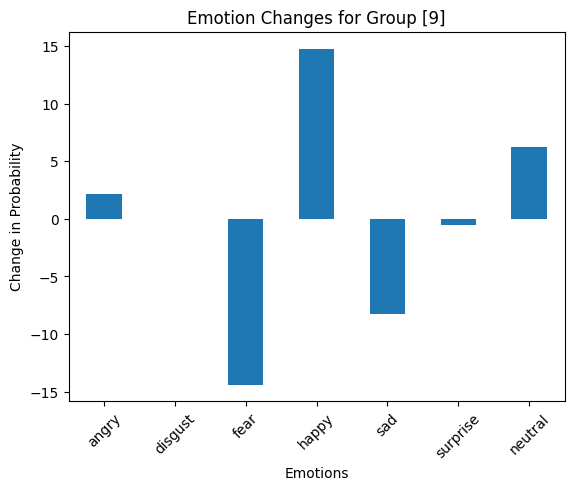

Emotion comparison results saved to 'emotion_comparison_results.csv'.


In [9]:
# CSV 파일 읽기
csv_file_path = "wemeet/deepface_emotions/emotion_analysis_full.csv"  # 업로드된 CSV 경로
data = pd.read_csv(csv_file_path)

# 그룹별 섭취 전후 프레임 나누기
grouped = data.groupby("Group")

# 결과 저장용 리스트
comparison_results = []

for group, group_data in grouped:
    group_data = group_data.sort_values("Frame")  # 프레임 순서대로 정렬
    
    # 최소 7프레임: 전 3프레임, 섭취, 후 3프레임
    if len(group_data) >= 7:
        # 전 3프레임, 섭취, 후 3프레임 나누기
        before_frames = group_data.iloc[:5]
        after_frames = group_data.iloc[-5:]
        
        # 감정 확률 평균 계산
        before_avg = before_frames["Emotion Probabilities"].apply(eval).apply(pd.Series).mean()
        after_avg = after_frames["Emotion Probabilities"].apply(eval).apply(pd.Series).mean()
        
        # 감정 변화 계산
        emotion_changes = after_avg - before_avg
        
        # 저장
        comparison_results.append({
            "Group": group,
            "Before Average": before_avg.to_dict(),
            "After Average": after_avg.to_dict(),
            "Emotion Changes": emotion_changes.to_dict()
        })

        # 출력
        print(f"Group {group}:")
        print(f"  Before Average: {before_avg}")
        print(f"  After Average: {after_avg}")
        print(f"  Emotion Changes: {emotion_changes}")

        # 시각화
        emotion_changes.plot(kind="bar", title=f"Emotion Changes for Group {group}")
        plt.ylabel("Change in Probability")
        plt.xlabel("Emotions")
        plt.xticks(rotation=45)
        plt.show()

# 결과를 DataFrame으로 변환
comparison_df = pd.DataFrame(comparison_results)

# 결과 저장
comparison_df.to_csv("wemeet/deepface_emotions/1emotion_analysis_full.csv", index=False)
print("Emotion comparison results saved to 'emotion_comparison_results.csv'.")


=== Final Emotion Scores (Single Values) ===
Positive Emotion Score: 49.8712
Negative Emotion Score: 0.0000
Neutral Emotion Score: 50.1288


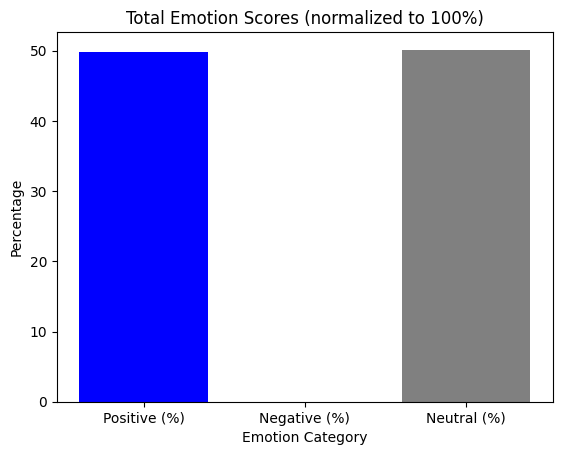

In [10]:
# CSV 파일 읽기
import ast
csv_file_path = "wemeet/deepface_emotions/1emotion_analysis_full.csv"
data = pd.read_csv(csv_file_path)

# 비교 결과 리스트 생성
comparison_results = []

# CSV에서 데이터를 변환하여 사용
for _, row in data.iterrows():
    comparison_results.append({
        "Emotion Changes": ast.literal_eval(row["Emotion Changes"])  # Emotion Changes를 딕셔너리로 변환
    })

# 감정 레이블 정의
positive_emotions = ["happy"]
negative_emotions = ["angry", "fear", "sad", "disgust"]
neutral_emotions = ["neutral"]

# 총 점수 계산용 변수
total_positive_score = 0
total_negative_score = 0
total_neutral_score = 0

# 감정 변화 합산
for result in comparison_results:
    emotion_changes = pd.Series(result["Emotion Changes"])

    # 감정별 점수 합산
    total_positive_score += emotion_changes[positive_emotions].sum()
    total_negative_score += emotion_changes[negative_emotions].sum()
    total_neutral_score += emotion_changes[neutral_emotions].sum()

# Min–Max 스케일링 수행
scores = np.array([total_positive_score, total_negative_score, total_neutral_score])
min_val, max_val = scores.min(), scores.max()

# 예외처리: max == min일 경우 (스코어 차이가 없을 때)
if max_val - min_val == 0:
    scaled_scores = np.ones_like(scores) / len(scores)  # 균등하게 33.3%씩 분배
else:
    scaled_scores = (scores - min_val) / (max_val - min_val)  # Min–Max 스케일링

# 정규화 (합을 100%로 변환)
normalized_scores = (scaled_scores / scaled_scores.sum()) * 100

# 최종 단일 숫자 값으로 저장
positive_emotion = normalized_scores[0]
negative_emotion = normalized_scores[1]
neutral_emotion = normalized_scores[2]

# 결과 출력
print("\n=== Final Emotion Scores (Single Values) ===")
print(f"Positive Emotion Score: {positive_emotion:.4f}")
print(f"Negative Emotion Score: {negative_emotion:.4f}")
print(f"Neutral Emotion Score: {neutral_emotion:.4f}")

# 총 점수 시각화
labels = ["Positive (%)", "Negative (%)", "Neutral (%)"]
plt.bar(labels, normalized_scores, color=["blue", "red", "gray"])
plt.title("Total Emotion Scores (normalized to 100%)")
plt.ylabel("Percentage")
plt.xlabel("Emotion Category")
plt.show()


In [11]:
# 가중치 설정
a = 0.8
b = 0.2

# Y 값 계산
Y_positive = a * positive_emotion + b * positive_behave
Y_negative = a * negative_emotion + b * negative_behave
Y_neutral = a * neutral_emotion  # 행동에는 중립 값이 없으므로 b 항 없음

# 결과 출력
print("\n=== Final Y Values ===")
print(f"Y_positive: {Y_positive:.4f}")
print(f"Y_negative: {Y_negative:.4f}")
print(f"Y_neutral: {Y_neutral:.4f}")


=== Final Y Values ===
Y_positive: 49.3436
Y_negative: 10.5534
Y_neutral: 40.1030


In [12]:
# 데이터 정의
data = {
    'id': ['Y_positive', 'Y_negative', 'Y_neutral'],
    'value': [Y_positive, Y_negative, Y_neutral] 
}

result_df = pd.DataFrame(data)

# 결과 저장
result_df.to_csv("wemeet/deepface_emotions/result.csv", index=False)

In [ ]:
import os
import json
import pandas as pd
import openai
import ast
import numpy as np
import re

# ✅ OpenAI API 키 설정 (최신 방식)


# ✅ 감정 분석 CSV 파일 로드
emotion_file_path = "wemeet\\deepface_emotions\\1emotion_analysis_full.csv"
df_emotion = pd.read_csv(emotion_file_path)

# ✅ 행동 분석 CSV 파일 로드
behavior_file_path = "movement_analysis_results.csv"
df_behavior = pd.read_csv(behavior_file_path)

# ✅ 감정 분석 컬럼 정리
df_emotion.columns = df_emotion.columns.str.strip()
for col in ["Before Average", "After Average", "Emotion Changes"]:
    df_emotion[col] = df_emotion[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# ✅ 감정 유형 정의
positive_emotions = ["happy", "surprise"]
negative_emotions = ["angry", "disgust", "fear", "sad"]
neutral_emotions = ["neutral"]

def categorize_emotions(changes):
    """ 감정을 긍정, 부정, 중립으로 정리하여 100% 정규화 """
    categorized = {"positive": 0, "negative": 0, "neutral": 0}
    for emotion, value in changes.items():
        if emotion in positive_emotions:
            categorized["positive"] += abs(value)
        elif emotion in negative_emotions:
            categorized["negative"] += abs(value)
        elif emotion in neutral_emotions:
            categorized["neutral"] += abs(value)

    total = sum(categorized.values())
    return {k: round((v / total) * 100, 2) if total > 0 else 0 for k, v in categorized.items()}

# ✅ 그룹 정렬
df_emotion["Group"] = df_emotion["Group"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_emotion["Group"] = df_emotion["Group"].apply(lambda x: x[0] if isinstance(x, list) else x)
df_emotion = df_emotion.sort_values(by="Group")

# ✅ 그룹별 감정 변화 저장
group_emotion = []
total_scores = {"positive": 0, "negative": 0, "neutral": 0}
emotion_trends = []

for index, (group, row) in enumerate(df_emotion.iterrows(), start=1):
    changes = row["Emotion Changes"]
    categorized_changes = categorize_emotions(changes)

    trend = "유지됨"
    if sum(row["After Average"].values()) > sum(row["Before Average"].values()):
        trend = "긍정 증가"
    elif sum(row["After Average"].values()) < sum(row["Before Average"].values()):
        trend = "부정 증가"

    emotion_trends.append({"group": f"섭취 {index}번째", "trend": trend})

    for key in categorized_changes:
        total_scores[key] += categorized_changes[key]

    group_emotion.append({
        "group": f"섭취 {index}번째",
        "group_number": group,
        "positive": categorized_changes["positive"],
        "negative": categorized_changes["negative"],
        "neutral": categorized_changes["neutral"]
    })

# ✅ 정규화
total_sum = sum(total_scores.values())
if total_sum > 0:
    total_scores = {k: round((v / total_sum) * 100, 2) for k, v in total_scores.items()}

# ✅ 행동 분석
df_behavior.columns = df_behavior.columns.str.strip()
df_behavior_numeric = df_behavior.drop(columns=["Image File"])
frame_behavior = df_behavior_numeric.groupby("Start Time (s)").mean().reset_index()

behavior_total = {
    "positive_behavior": round(df_behavior["Positive (%)"].mean(), 2),
    "negative_behavior": round(df_behavior["Negative (%)"].mean(), 2)
}

# ✅ 가중치 적용 (감정 80% + 행동 20%)
a, b = 0.8, 0.2
Y_positive = a * total_scores["positive"] + b * behavior_total["positive_behavior"]
Y_negative = a * total_scores["negative"] + b * behavior_total["negative_behavior"]
Y_neutral = a * total_scores["neutral"]

# ✅ JSON 데이터 생성
summary_prompt = {
    "summary": {
        "감정 토탈": total_scores,
        "그룹별 감정 분석": group_emotion,
        "행동 토탈": behavior_total,
        "프레임별 행동 분석": frame_behavior.to_dict(orient="records"),
        "총합 감정+행동": {
            "Y_positive": round(Y_positive, 2),
            "Y_negative": round(Y_negative, 2),
            "Y_neutral": round(Y_neutral, 2)
        }
    },
    "analysis": {
        "emotion_trends": emotion_trends,
        "comment": "감정 변화와 행동 변화를 통합 분석하여 소비자 인사이트를 제공합니다."
    }
}

# ✅ 중요 키워드 감지 및 볼드 적용
def extract_important_phrases(text):
    """GPT를 사용하여 중요 키워드를 JSON 리스트로 반환"""
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "당신은 텍스트 분석 전문가입니다.핵심이 될만한 단어들을 잘 찾아냅니다."},
            {"role": "user", "content": f"다음 텍스트에서 중요한 단어나 문구를 JSON 리스트로 반환하세요: {text}"}
        ],
        temperature=0.5
    )

    raw_response = response.choices[0].message.content.strip()
    try:
        important_phrases = json.loads(raw_response)
        if not isinstance(important_phrases, list):
            raise ValueError("JSON 리스트 아님")
    except (json.JSONDecodeError, ValueError):
        important_phrases = re.findall(r'"(.*?)"', raw_response)

    return [phrase for phrase in important_phrases if isinstance(phrase, str)]

def apply_bold(text, important_phrases):
    """중요 키워드에 볼드 적용"""
    for phrase in important_phrases:
        text = re.sub(rf"\b{re.escape(phrase)}\b", f"<b>{phrase}</b>", text)
    return text

# ✅ ChatGPT 분석 및 볼드 적용
analysis_responses = {}

for analysis_type, instruction in {
    "total_analysis": "햄버거 소비와 관련하여 감정 및 행동 분석을 바탕으로 판매 전략과 개선 방안을 제안하세요.",
    "emotion_analysis": "햄버거 소비와 관련하여 감정 변화만을 분석하고, 그룹별 감정 변화 패턴을 설명하세요.",
    "behavior_analysis": "햄버거 소비와 관련하여 행동 데이터만을 분석하고, 행동 변화 패턴을 설명하세요."
}.items():
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "당신은 감정 및 행동 분석 전문가이며 번창한 햄버거집 사장님으로 판매전략에 있어 유능합니다."},
            {"role": "user", "content": json.dumps({"summary": summary_prompt["summary"], "analysis": instruction}, ensure_ascii=False)}
        ],
        temperature=0.7
    )

    original_text = response.choices[0].message.content
    important_phrases = extract_important_phrases(original_text)
    formatted_response = apply_bold(original_text, important_phrases)

    analysis_responses[analysis_type] = formatted_response

# ✅ JSON 저장
json_output_path = "wemeet\\deepface_emotions\\final_emotion_behavior_analysis.json"
final_json = {"summary": summary_prompt["summary"], "analysis": analysis_responses}

with open(json_output_path, "w", encoding="utf-8") as json_file:
    json.dump(final_json, json_file, ensure_ascii=False, indent=4)

print(json.dumps(final_json, ensure_ascii=False, indent=4))
